# Town and State Data Exploration

How can we exploit the town/state data to estimate the demand and inventory?

Here are possible solutions?
* Presentation: We can find the coordinates of each town/state and draw a heatmap of the demand and its return. 
**Review the lecture heatmap code (/1_Problem_Session_2_Complete.ipynb)**
* Town variable does not seem to represent "town" but rather sales depot area.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import geopandas as gpd
from shapely.ops import unary_union

sns.set_style("whitegrid")

## Cleaning town_state dataset

In [2]:
town_state = pd.read_csv('grupo-bimbo-inventory-demand/town_state.csv.zip', compression="zip")
town_state = town_state.rename(columns={'Agencia_ID': 'Sales_Depot_ID',
                          'Town': 'Town',
                          'State': 'State'})
town_state['State'] = town_state['State'].str.upper()
town_state['State'] = town_state['State'].str.replace("É", "E")
town_state['State'] = town_state['State'].str.replace("Ó", "O")
town_state['State'] = town_state['State'].str.replace("Á", "A")
town_state['State'] = town_state['State'].str.replace("Í", "I")
town_state.loc[town_state['State'] == 'QUERETARO DE ARTEAGA', 'State'] = 'QUERETARO'

What are the Mexican states' names?

In [3]:
town_state['State'].sort_values().unique()

array(['AGUASCALIENTES', 'BAJA CALIFORNIA NORTE', 'BAJA CALIFORNIA SUR',
       'CAMPECHE', 'CHIAPAS', 'CHIHUAHUA', 'COAHUILA', 'COLIMA',
       'DURANGO', 'ESTADO DE MEXICO', 'GUANAJUATO', 'GUERRERO', 'HIDALGO',
       'JALISCO', 'MEXICO, D.F.', 'MICHOACAN', 'MORELOS', 'NAYARIT',
       'NUEVO LEON', 'OAXACA', 'PUEBLA', 'QUERETARO', 'QUINTANA ROO',
       'SAN LUIS POTOSI', 'SINALOA', 'SONORA', 'TABASCO', 'TAMAULIPAS',
       'TLAXCALA', 'VERACRUZ', 'YUCATAN', 'ZACATECAS'], dtype=object)

Which towns are in "BAJA CALIFORNIA"?

In [4]:
town_state[town_state['State'] == "BAJA CALIFORNIA NORTE"]['Town'].unique()

array(['2563 MEXICALI PONIENTE', '2152 Cruce De Anden Noroeste',
       '2555 ENSENADA II', '2572 TIJUANA EL FLORIDO',
       '2573 TIJUANA GATO BRONCO', '2574 TIJUANA PACIFICO', '2571 TECATE',
       '2562 MEXICALI PLAZA', '2569 SAN QUINTÍN', '2575 TIJUANA ROSARITO'],
      dtype=object)

## Cleaning Mexico GeoJson
I cloned Mexico GeoJson data from [link](https://github.com/PhantomInsights/mexico-geojson). This dataset provides the coordinates for each state and city in Mexico for 2020-2022. I loop over all files in the folder and create geo_data.

In [ ]:
geo_data_dir = 'mexico-geojson/2020/states'
geo_data = gpd.GeoDataFrame()

for filename in os.listdir(geo_data_dir):
    if filename.endswith('.json'):
        print(filename)
        file_path = os.path.join(geo_data_dir, filename)
        tmp_data = gpd.read_file(file_path)
        geo_data = pd.concat([geo_data, tmp_data],ignore_index = True)

del tmp_data


Aguascalientes.json
Baja California Sur.json
Baja California.json
Campeche.json
Chiapas.json
Chihuahua.json
Ciudad de México.json
Coahuila de Zaragoza.json
Colima.json
Durango.json
Guanajuato.json
Guerrero.json
Hidalgo.json
Jalisco.json
Michoacán de Ocampo.json
Morelos.json
México.json
Nayarit.json
Nuevo León.json
Oaxaca.json
Puebla.json
Querétaro.json
Quintana Roo.json
San Luis Potosí.json
Sinaloa.json
Sonora.json
Tabasco.json
Tamaulipas.json
Tlaxcala.json
Veracruz de Ignacio de la Llave.json
Yucatán.json
Zacatecas.json


Let's rename the columns and standardize spanish letters and names.

In [6]:
geo_data = geo_data.rename(columns={'NOM_ENT':'State',
                                    'NOM_MUN': 'Municipality'})
geo_data['State'] = geo_data['State'].str.upper()
geo_data['State'] = geo_data['State'].str.replace("É", "E")
geo_data['State'] = geo_data['State'].str.replace("Ó", "O")
geo_data['State'] = geo_data['State'].str.replace("Á", "A")
geo_data['State'] = geo_data['State'].str.replace("Í", "I")
geo_data.loc[geo_data['State'] == 'MEXICO', 'State'] = 'ESTADO DE MEXICO'
geo_data.loc[geo_data['State'] == 'CIUDAD DE MEXICO', 'State'] = 'MEXICO, D.F.'
geo_data.loc[geo_data['State'] == 'MICHOACAN DE OCAMPO', 'State'] = 'MICHOACAN'
geo_data.loc[geo_data['State'] == 'COAHUILA DE ZARAGOZA', 'State'] = 'COAHUILA'
geo_data.loc[geo_data['State'] == 'BAJA CALIFORNIA', 'State'] = 'BAJA CALIFORNIA NORTE'
geo_data.loc[geo_data['State'] == 'VERACRUZ DE IGNACIO DE LA LLAVE', 'State'] = 'VERACRUZ'

geo_data['State'].unique()

array(['AGUASCALIENTES', 'BAJA CALIFORNIA SUR', 'BAJA CALIFORNIA NORTE',
       'CAMPECHE', 'CHIAPAS', 'CHIHUAHUA', 'MEXICO, D.F.', 'COAHUILA',
       'COLIMA', 'DURANGO', 'GUANAJUATO', 'GUERRERO', 'HIDALGO',
       'JALISCO', 'MICHOACAN', 'MORELOS', 'ESTADO DE MEXICO', 'NAYARIT',
       'NUEVO LEON', 'OAXACA', 'PUEBLA', 'QUERETARO', 'QUINTANA ROO',
       'SAN LUIS POTOSI', 'SINALOA', 'SONORA', 'TABASCO', 'TAMAULIPAS',
       'TLAXCALA', 'VERACRUZ', 'YUCATAN', 'ZACATECAS'], dtype=object)

The geo_data is aggregated at the city level. I aggregate the dataset to the state level. To do so, I use the *shapely* library.

In [36]:
unified_geometries = geo_data.groupby('State')['geometry'].apply(lambda x: x.unary_union).reset_index()

C:\Users\amirh\AppData\Local\Temp\ipykernel_23692\4216380218.py:1: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  unified_geometries = geo_data.groupby('State')['geometry'].apply(lambda x: x.unary_union).reset_index()


This is a representation of the above code for the state Chiapas.

<Axes: >

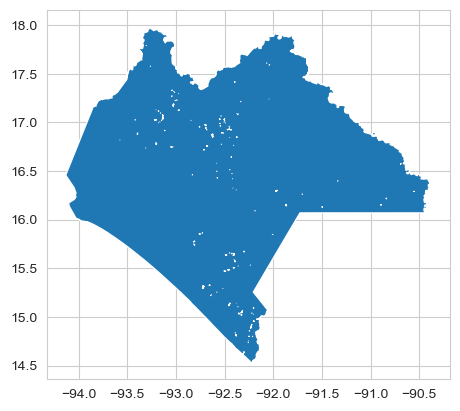

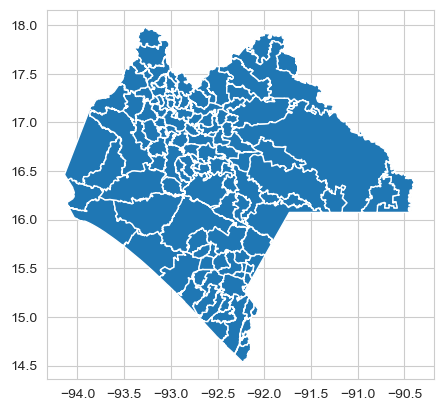

In [8]:
mexico_polygon = geo_data[geo_data['State'] == 'CHIAPAS']
combine_polygon = unary_union(mexico_polygon.geometry)

combined_gdf = gpd.GeoDataFrame({'State': ['CHIAPAS'], 'geometry': [combine_polygon]})
combined_gdf.plot()
geo_data[geo_data['State'] == 'CHIAPAS'].plot()

In [ ]:
# town_state = town_state.merge(unified_geometries, how='left', on = 'State')
# town_state.head()

,Sales_Depot_ID,Town,State,geometry
0,1110,2008 AG. LAGO FILT,"MEXICO, D.F.","POLYGON ((-99.17823 19.09247, -99.22108 19.095..."
1,1111,2002 AG. AZCAPOTZALCO,"MEXICO, D.F.","POLYGON ((-99.17823 19.09247, -99.22108 19.095..."
2,1112,2004 AG. CUAUTITLAN,ESTADO DE MEXICO,"POLYGON ((-100.0701 18.57654, -100.07006 18.57..."
3,1113,2008 AG. LAGO FILT,"MEXICO, D.F.","POLYGON ((-99.17823 19.09247, -99.22108 19.095..."
4,1114,2029 AG.IZTAPALAPA 2,"MEXICO, D.F.","POLYGON ((-99.17823 19.09247, -99.22108 19.095..."


In [ ]:
#Is there any unmatched state?
# no!
# town_state[town_state['geometry'].isna()].State.unique()

array([], dtype=object)

## Demand Heatmap
We have the states' geoCoordinates. Now let's read the demand data, aggregate it at the state level and create the heatmap.

In [45]:
# Define the chunk size
chunk_size = 4000000  # Adjust the chunk size based on your memory capacity
chunks = pd.read_csv('grupo-bimbo-inventory-demand/train.csv/train.csv', chunksize=chunk_size)

# Now you can work with the 'train' DataFrame
train = next(chunks)

# Rename columns
train = train.rename(columns={'Semana': 'Week_num',
                                  'Agencia_ID': 'Sales_Depot_ID',
                                  'Canal_ID': 'Sales_Channel_ID',
                                  'Ruta_SAK': 'Route_ID',
                                  'Cliente_ID': 'Client_ID',
                                  'Venta_uni_hoy': 'Sales_unit_this_week',
                                  'Venta_hoy': 'Sales_this_week',
                                  'Dev_uni_proxima': 'Returns_unit_next_week',
                                  'Dev_proxima': 'Returns_next_week',
                                  'Demanda_uni_equil': 'Adjusted_demand',
                                  'Producto_ID': 'Product_ID'})

# merge in state variable into the main dataset
train = train.merge(town_state[['Sales_Depot_ID', 'State']], on='Sales_Depot_ID', how='left', copy=False )

state_demand = train.groupby(['State'], as_index=False).agg({
                                                            'Sales_unit_this_week': 'sum',
                                                            'Sales_this_week': 'sum',
                                                            'Returns_unit_next_week': 'sum',
                                                            'Returns_next_week': 'sum',
                                                            'Adjusted_demand': 'sum',
                                                            'Client_ID': 'nunique',
                                                            }).reset_index()
state_demand = state_demand.rename(columns={'Client_ID': 'Unique_clients'})

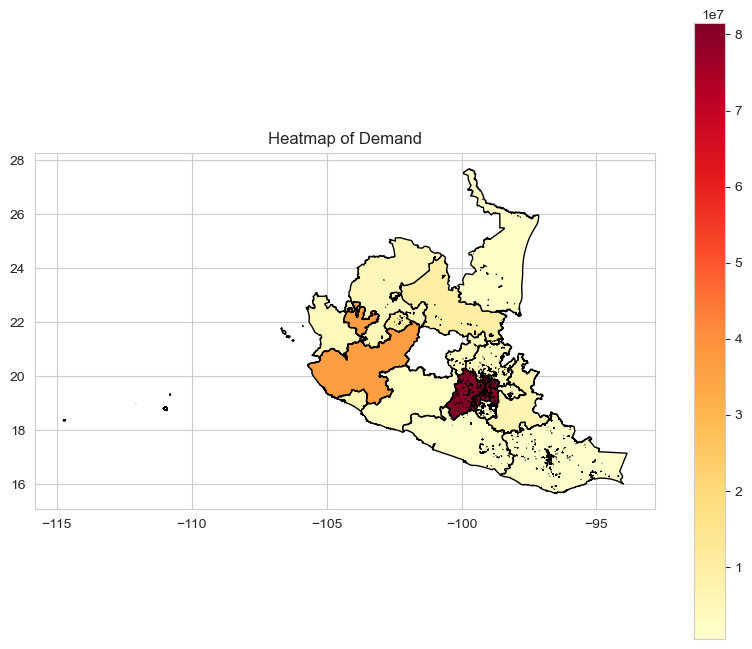

In [48]:
ug = unified_geometries.merge(state_demand, how='outer', on='State', copy=False)

ug.plot(column='Sales_this_week', cmap='YlOrRd', legend=True, edgecolor='black',figsize = (10,8))

# Add title and display the heatmap
plt.title('Heatmap of Demand')
plt.show()